# CNN모델

In [7]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from konlpy.tag import Okt
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
# CSV 파일 읽기
df = pd.read_csv("./라벨링완료된공지사항(수정본).csv") 

notice_names = df['title'].tolist()

# 전처리 함수 정의
def preprocess_text(text):
    # 특수문자 제거
    text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", text)

    # 숫자 정보 제거
    text = re.sub(r'\d+', '', text)

    # 형태소 분석
    tagger = Okt()
    words = tagger.morphs(text)

    # 불용어 제거
    stop_words = ['필독', '학기', '학년', '도', '년', '제', '회', '월', '학부', '일', '차', '년도', '안내']  # 불용어 리스트
    words = [word for word in words if word not in stop_words]

    # 분석된 형태소들을 공백으로 결합하여 문장으로 반환
    text = ' '.join(words)

    return text


preprocessed_notice_names = [preprocess_text(notice_name) for notice_name in notice_names]

In [9]:
# 토크나이저 생성
tokenizer = Tokenizer()

# 토크나이저가 데이터를 학습
tokenizer.fit_on_texts(preprocessed_notice_names)

# 데이터를 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(preprocessed_notice_names)

# 가장 긴 문장의 길이를 확인
max_sequence_length = max(len(s) for s in sequences)
print('가장 긴 문장의 길이:', max_sequence_length)

# 어휘 사전의 크기를 확인 (+1을 하는 이유는 0인덱스를 고려하기 때문입니다.)
vocab_size = len(tokenizer.word_index) + 1
print('어휘 사전의 크기:', vocab_size)

# 모든 문장을 가장 긴 문장의 길이로 패딩 처리
padded_X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

가장 긴 문장의 길이: 29
어휘 사전의 크기: 6097


In [27]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_notice_names)

tfidf_model = TfidfVectorizer().fit(preprocessed_notice_names)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])

In [28]:
# 훈련 데이터 분리: train 데이터 80%, test 데이터 20%
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size=0.2, random_state=42)

In [29]:
# 타겟 변수 다중 클래스 원-핫 인코딩
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [30]:
# CNN 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_sequence_length))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))

# 출력 뉴런의 개수와 활성화 함수를 클래스 개수에 따라 조정
num_classes = len(set(y))  # 클래스 개수 계산
if num_classes == 2:
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
else:
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
#모델 훈현
model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
251/251 [==============================] - 6s 17ms/step - loss: 2.7673 - accuracy: 0.3723 - val_loss: 1.3757 - val_accuracy: 0.6760
Epoch 2/10
251/251 [==============================] - 4s 15ms/step - loss: 0.6508 - accuracy: 0.8514 - val_loss: 0.4569 - val_accuracy: 0.8977
Epoch 3/10
251/251 [==============================] - 5s 20ms/step - loss: 0.1754 - accuracy: 0.9647 - val_loss: 0.3377 - val_accuracy: 0.9161
Epoch 4/10
251/251 [==============================] - 4s 15ms/step - loss: 0.0609 - accuracy: 0.9895 - val_loss: 0.3047 - val_accuracy: 0.9221
Epoch 5/10
251/251 [==============================] - 4s 16ms/step - loss: 0.0264 - accuracy: 0.9956 - val_loss: 0.3270 - val_accuracy: 0.9191
Epoch 6/10
251/251 [==============================] - 5s 20ms/step - loss: 0.0160 - accuracy: 0.9976 - val_loss: 0.3462 - val_accuracy: 0.9196
Epoch 7/10
251/251 [==============================] - 4s 16ms/step - loss: 0.0135 - accuracy: 0.9974 - val_loss: 0.3156 - val_accuracy: 0.9256

In [36]:
# 새로운 입력 데이터 예측
new_text = input("새로운 문장을 입력하세요: ")
preprocessed_new_text = preprocess_text(new_text)
sequence = tokenizer.texts_to_sequences([preprocessed_new_text])
padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
prediction = model.predict(padded_sequence)
predicted_label = label_encoder.inverse_transform([prediction.argmax()])[0]

# 예측 결과 출력
print(f"입력 문장: {new_text}")
print(f"예측된 레이블: {predicted_label}")

새로운 문장을 입력하세요: 6월 7일 모의토익 고사장 및 성적 확인 방법 안내
1/1 [==============================] - 0s 45ms/step
입력 문장: 6월 7일 모의토익 고사장 및 성적 확인 방법 안내
예측된 레이블: 시험


In [32]:
y_prob = model.predict(X_test, verbose=0) 
y_pred = y_prob.argmax(axis=-1)
CNN_accuracy = np.sum(y_pred.flatten() == y_test) / len(y_test)
print("Accuracy:", CNN_accuracy)

Accuracy: 0.9256115826260609


# LSTM모델

In [16]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from konlpy.tag import Okt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM

In [18]:
# CSV 파일 읽기
df = pd.read_csv("./라벨링완료된공지사항(수정본).csv") 

notice_names = df['title'].tolist()

# 전처리 함수 정의
def preprocess_text(text):
    # 특수문자 제거
    text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", text)

    # 숫자 정보 제거
    text = re.sub(r'\d+', '', text)

    # 형태소 분석
    tagger = Okt()
    words = tagger.morphs(text)

    # 불용어 제거
    stop_words = ['필독', '학기', '학년', '도', '년', '제', '회', '월', '학부', '일', '차', '년도', '안내']  # 불용어 리스트
    words = [word for word in words if word not in stop_words]

    # 분석된 형태소들을 공백으로 결합하여 문장으로 반환
    text = ' '.join(words)

    return text


preprocessed_notice_names = [preprocess_text(notice_name) for notice_name in notice_names]

In [19]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_notice_names)

tfidf_model = TfidfVectorizer().fit(preprocessed_notice_names)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])

In [20]:
# 토크나이저 생성
tokenizer = Tokenizer()

# 토크나이저가 데이터를 학습
tokenizer.fit_on_texts(preprocessed_notice_names)

# 데이터를 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(preprocessed_notice_names)

# 가장 긴 문장의 길이를 확인
max_sequence_length = max(len(s) for s in sequences)
print('가장 긴 문장의 길이:', max_sequence_length)

# 어휘 사전의 크기를 확인 (+1을 하는 이유는 0인덱스를 고려하기 때문입니다.)
vocab_size = len(tokenizer.word_index) + 1
print('어휘 사전의 크기:', vocab_size)

# 모든 문장을 가장 긴 문장의 길이로 패딩 처리
padded_X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

가장 긴 문장의 길이: 29
어휘 사전의 크기: 6097


In [21]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_notice_names)

tfidf_model = TfidfVectorizer().fit(preprocessed_notice_names)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])

In [22]:
# 훈련 데이터 분리: train 데이터 80%, test 데이터 20%
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size=0.2, random_state=42)

In [23]:
# 타겟 변수 다중 클래스 원-핫 인코딩
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [24]:
# LSTM 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_sequence_length))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))

# 출력 뉴런의 개수와 활성화 함수를 클래스 개수에 따라 조정
num_classes = len(set(y))  # 클래스 개수 계산
if num_classes == 2:
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
else:
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# 모델 훈련
model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test, y_test_encoded))

Epoch 1/50
251/251 [==============================] - 14s 42ms/step - loss: 3.6713 - accuracy: 0.0879 - val_loss: 3.4627 - val_accuracy: 0.0884
Epoch 2/50
251/251 [==============================] - 9s 35ms/step - loss: 3.4479 - accuracy: 0.1019 - val_loss: 3.5820 - val_accuracy: 0.1018
Epoch 3/50
251/251 [==============================] - 8s 30ms/step - loss: 3.5486 - accuracy: 0.0909 - val_loss: 3.5353 - val_accuracy: 0.0859
Epoch 4/50
251/251 [==============================] - 9s 34ms/step - loss: 3.4456 - accuracy: 0.1009 - val_loss: 3.4913 - val_accuracy: 0.0879
Epoch 5/50
251/251 [==============================] - 8s 34ms/step - loss: 3.4275 - accuracy: 0.1036 - val_loss: 3.4941 - val_accuracy: 0.0864
Epoch 6/50
251/251 [==============================] - 8s 30ms/step - loss: 3.4233 - accuracy: 0.1049 - val_loss: 3.4906 - val_accuracy: 0.0884
Epoch 7/50
251/251 [==============================] - 9s 36ms/step - loss: 3.4351 - accuracy: 0.1021 - val_loss: 3.5347 - val_accuracy: 0.089

In [26]:
y_prob = model.predict(X_test, verbose=0) 
y_pred = y_prob.argmax(axis=-1)
LSTM_accuracy = np.sum(y_pred.flatten() == y_test) / len(y_test)
print("Accuracy:", LSTM_accuracy)

Accuracy: 0.8597104343484773


# 성능 비교 시각화

In [39]:
import matplotlib.pyplot as plt

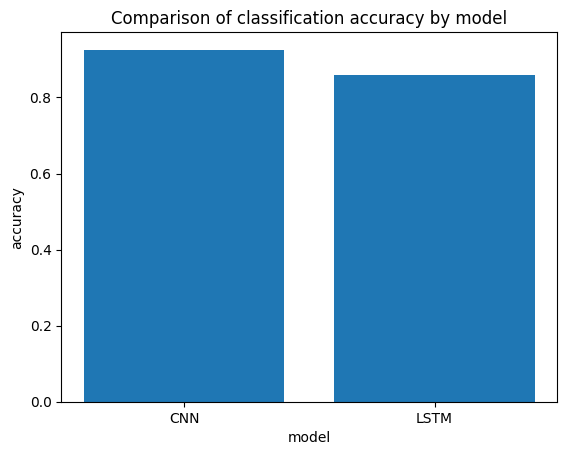

In [40]:
#그래프로 성능 비교 

x = ('CNN', 'LSTM')
y = [CNN_accuracy, LSTM_accuracy]
plt.xlabel("model")
plt.ylabel("accuracy")
plt.bar(x, y)  # 데이터 가로 나온 함수 barh
plt.title('Comparison of classification accuracy by model')

plt.show()
